# Variance Reduction Techniques

We will continue with Importance sampling, but now we will consider Asian Options. This means we will have to sample multiple timesteps. Therefore we have to deal with a vector of random variables and as such a vector of $\mu$. 

We will first use the same $\mu$ for all timesteps, but later we try to find more optimal $\mu$'s for each timestep.

$\textbf{Theory from a lecture at LMU by Dr. Ari-Pekka Perkkiö}$

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

import fima

In [2]:
T = 1
t = 0
x = 1
K = 1.1
r = 0.05
sigma = 0.2

In [3]:
M_vanilla = 100000 # number of simulations for vanilla option

M_exotic = 5000 # number of simulations for exotic option
steps_exotic = 1000

Lets first try a constant $\mu$ for all timesteps.

In [4]:
eta = np.random.normal(size = (T*steps_exotic,M_exotic))

In [5]:
constant_drift = np.ones(T*steps_exotic)*0.01

In [6]:
K = 0.8

basic_means, basic_interval_range = fima.basic_mc(t, x, eta, lambda S: fima.asian_call_payoff(S, K), r, sigma, T)
is_means, is_interval_range = fima.mc_importance_sampling(t, x, eta, lambda S: fima.asian_call_payoff(S, K), constant_drift, r, sigma, T)

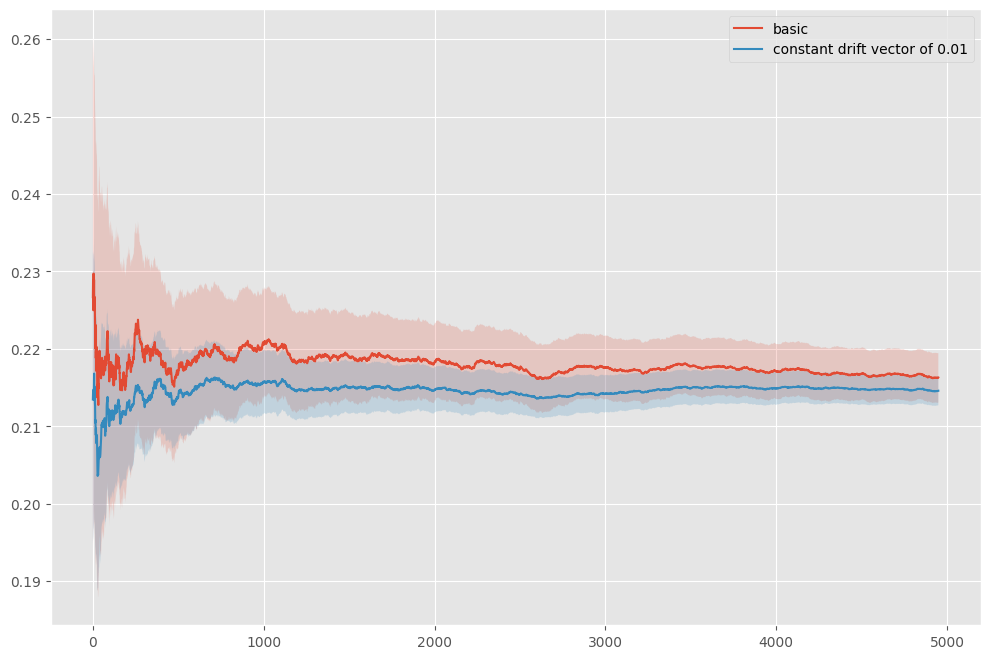

In [7]:
fima.plot_mc(basic_means, basic_interval_range, 'basic')
fima.plot_mc(is_means, is_interval_range, 'constant drift vector of ' + str(constant_drift[0]))
plt.legend();

Now lets try to find a better $\mu$ for each timestep.

We will start by finding the optimal constant $\mu$.

In [8]:
def polyeval(p):
    return np.array([np.polyval(p, i) for i in np.linspace(0, T, T*steps_exotic)])

In [9]:
def mc_importance_sampling_optimal_drift_vec(t, x, eta, optimize_eta, degree, payoff, r, sigma, T):
    g_h = lambda x_, drift_: np.exp(-np.dot(drift_,x_) + 0.5*np.dot(drift_, drift_)).flatten()

    assets = lambda eta_ : fima.GBMpaths(x, r, sigma, T - t, eta_)

    optimize_func = lambda p : np.mean(payoff(assets(optimize_eta))**2*g_h(optimize_eta, polyeval(p)))

    optimize_result = scipy.optimize.minimize(optimize_func, np.zeros(degree + 1), bounds = np.array([(-0.3, 0.3) for i in range(degree + 1)]), tol = 1e-12)

    optimized_drift = polyeval(optimize_result.x)

    payoffs = np.exp(-r*(T-t)) * payoff(assets(eta + optimized_drift[:,np.newaxis]))*g_h(eta + optimized_drift[:,np.newaxis], optimized_drift)

    means = np.cumsum(payoffs) / np.arange(1, len(payoffs) + 1)

    #we should do this but this is way to slow in python if implemented like this
    #interval_range = 1.96 * ([np.std(payoffs[:n]) for n in range(1, len(payoffs) + 1)] / np.sqrt(np.arange(1, len(payoffs) + 1)))
    #so we do this instead
    interval_range = 1.96 * np.std(payoffs) / np.sqrt(np.arange(1, len(payoffs) + 1))

    return means, interval_range, optimized_drift, optimize_result

In [10]:
optimize_eta = np.random.normal(size = (T*steps_exotic,int(M_exotic/10)))

In [11]:
is_0_means, is_0_interval_range, _, is_0_optimize_result = mc_importance_sampling_optimal_drift_vec(t, x, eta, optimize_eta, 0, lambda S: fima.asian_call_payoff(S, K), r, sigma, T)

In [12]:
is_0_optimize_result.x

array([0.01457162])

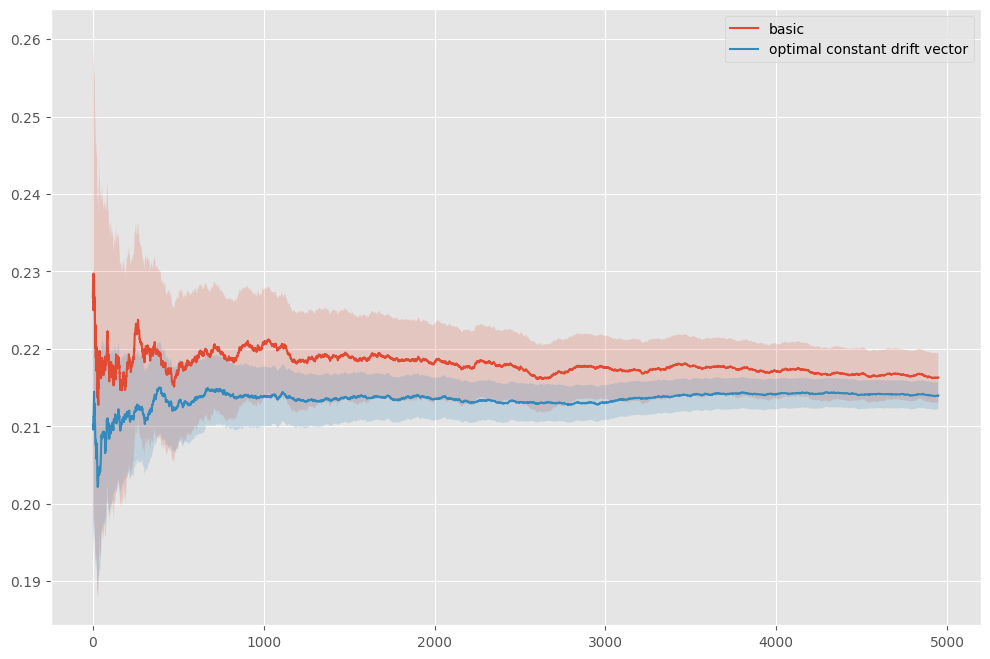

In [13]:
fima.plot_mc(basic_means, basic_interval_range, 'basic')
fima.plot_mc(is_0_means, is_0_interval_range, 'optimal constant drift vector')
plt.legend();

Lets fit a linear/quadratic function as the optimal $\mu$

In [14]:
is_1_means, is_1_interval_range, _, is_1_optimize_result = mc_importance_sampling_optimal_drift_vec(t, x, eta, optimize_eta, 1, lambda S: fima.asian_call_payoff(S, K), r, sigma, T)
is_2_means, is_2_interval_range, _, is_2_optimize_result = mc_importance_sampling_optimal_drift_vec(t, x, eta, optimize_eta, 2, lambda S: fima.asian_call_payoff(S, K), r, sigma, T)

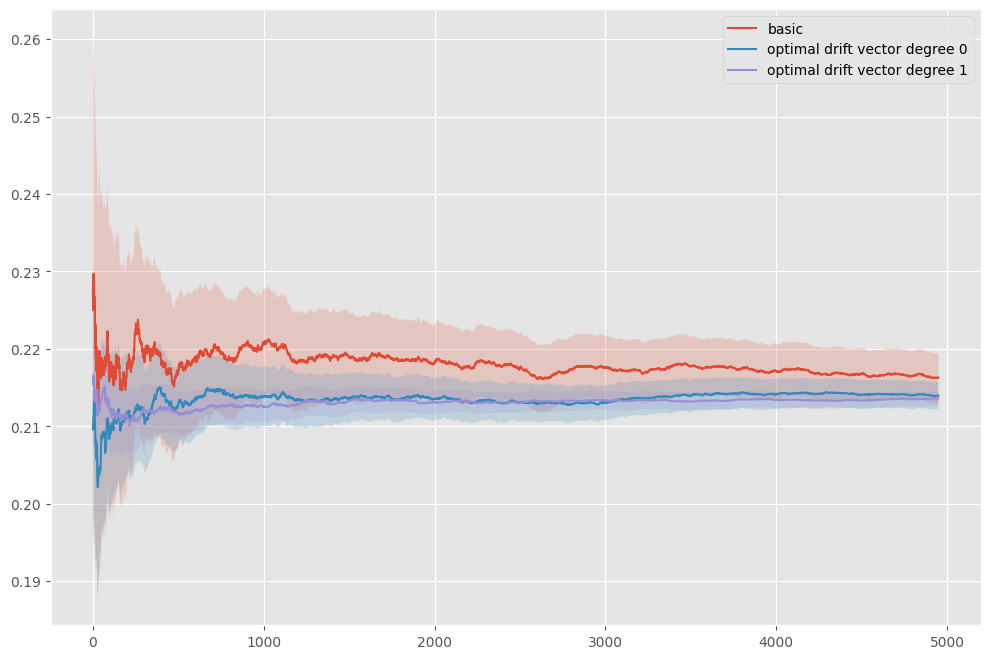

In [15]:
fima.plot_mc(basic_means, basic_interval_range, 'basic')
fima.plot_mc(is_0_means, is_0_interval_range, 'optimal drift vector degree 0')
fima.plot_mc(is_1_means, is_1_interval_range, 'optimal drift vector degree 1')
plt.legend();

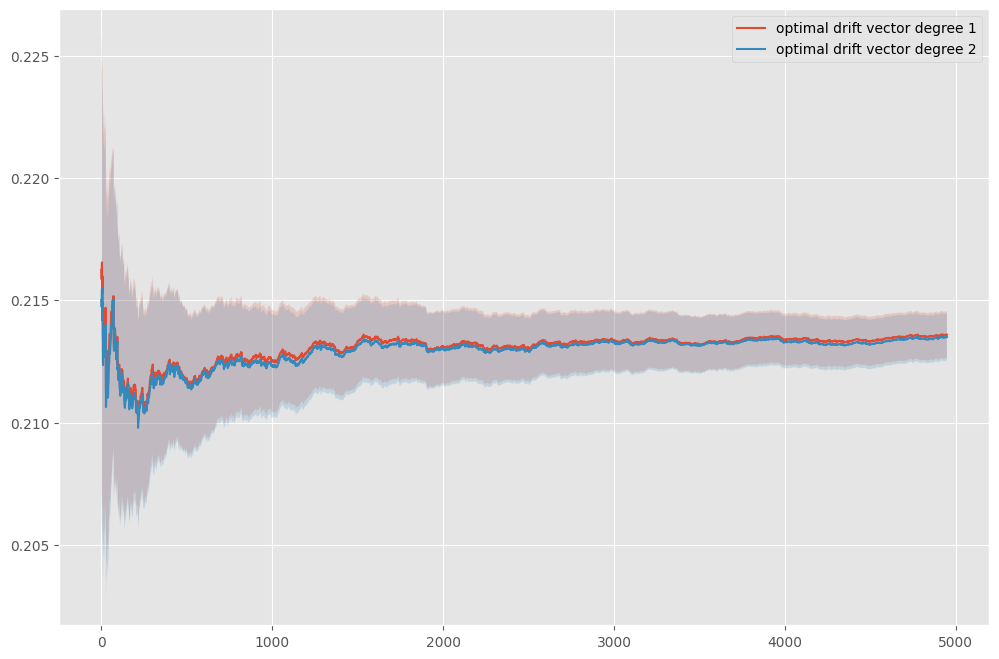

In [16]:
fima.plot_mc(is_1_means, is_1_interval_range, 'optimal drift vector degree 1')
fima.plot_mc(is_2_means, is_2_interval_range, 'optimal drift vector degree 2')
plt.legend();

No real difference between degree 1 and 2

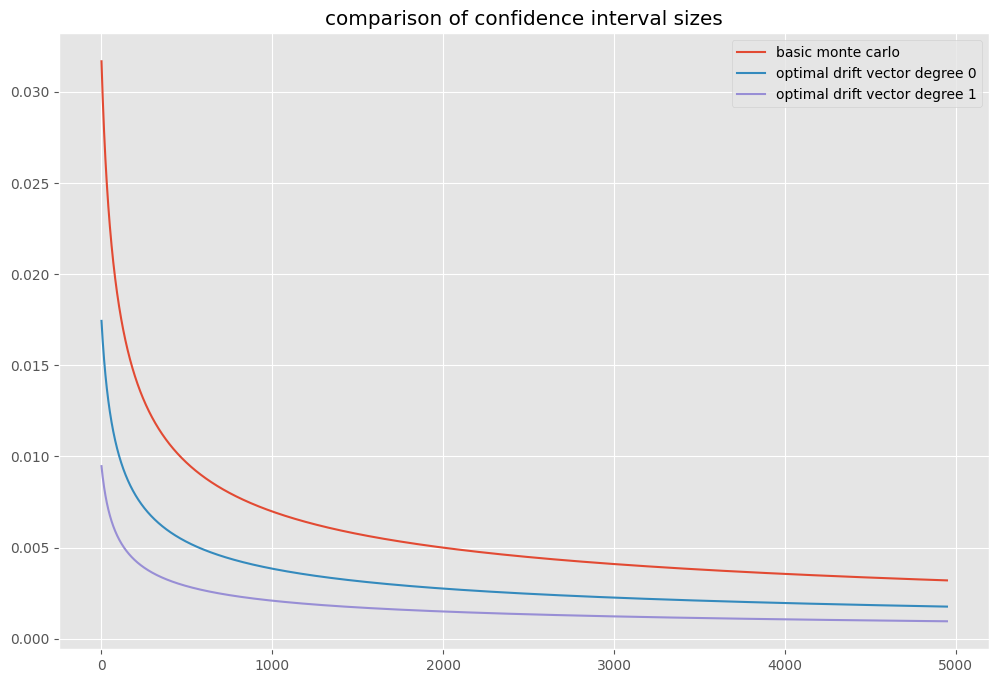

In [17]:
plt.plot(basic_interval_range[int(len(basic_interval_range) * fima.plot_bound):], label = 'basic monte carlo')
plt.plot(is_0_interval_range[int(len(is_0_interval_range) * fima.plot_bound):], label = 'optimal drift vector degree 0')
plt.plot(is_1_interval_range[int(len(is_1_interval_range) * fima.plot_bound):], label = 'optimal drift vector degree 1')
plt.title('comparison of confidence interval sizes')
plt.legend();

Lets see how those drift vectors look like

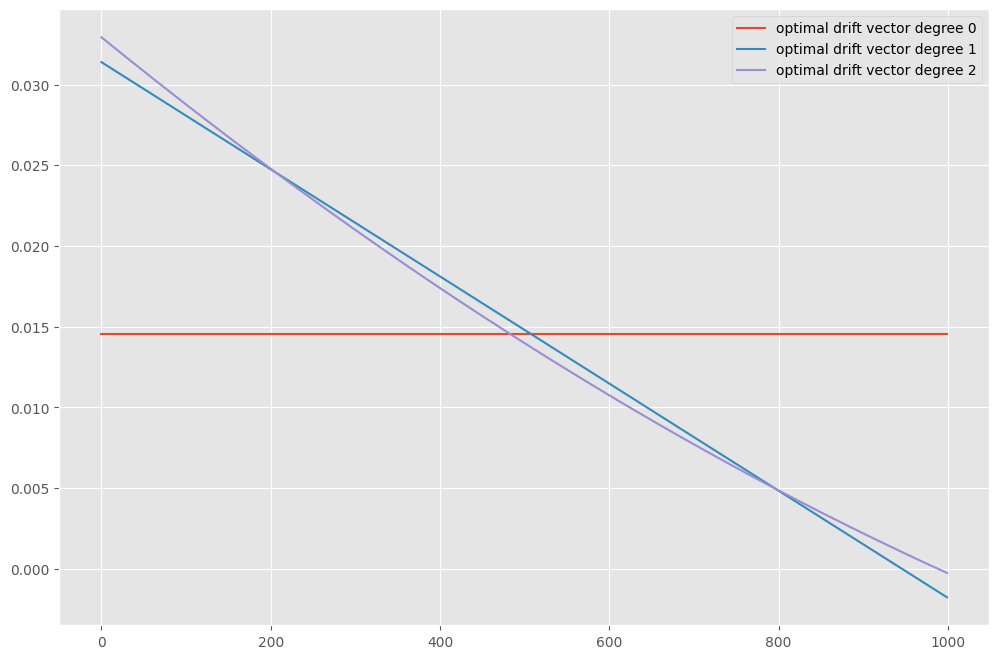

In [18]:
plt.plot(polyeval(is_0_optimize_result.x), label = 'optimal drift vector degree 0')
plt.plot(polyeval(is_1_optimize_result.x), label = 'optimal drift vector degree 1')
plt.plot(polyeval(is_2_optimize_result.x), label = 'optimal drift vector degree 2')
plt.legend();

Lets focus on the linear interpolation and compare in/out of the money and Put/Call

In [19]:
is_itm_call_means, is_itm_call_interval_range, _, is_itm_call_optimize_result = mc_importance_sampling_optimal_drift_vec(t, x, eta, optimize_eta, 1, lambda S: fima.asian_call_payoff(S, 0.8), r, sigma, T)
is_otm_call_means, is_otm_call_interval_range, _, is_otm_call_optimize_result = mc_importance_sampling_optimal_drift_vec(t, x, eta, optimize_eta, 1, lambda S: fima.asian_call_payoff(S, 1.2), r, sigma, T)

is_itm_put_means, is_itm_put_interval_range, _, is_itm_put_optimize_result = mc_importance_sampling_optimal_drift_vec(t, x, eta, optimize_eta, 1, lambda S: fima.asian_put_payoff(S, 1.2), r, sigma, T)
is_otm_put_means, is_otm_put_interval_range, _, is_otm_put_optimize_result = mc_importance_sampling_optimal_drift_vec(t, x, eta, optimize_eta, 1, lambda S: fima.asian_put_payoff(S, 0.8), r, sigma, T)

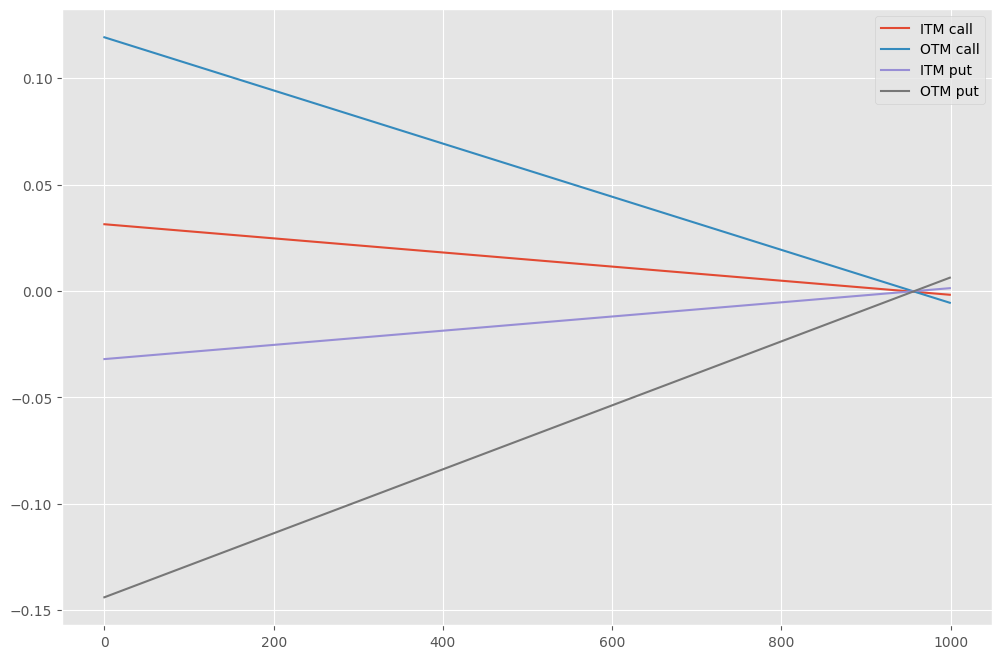

In [20]:
plt.plot(polyeval(is_itm_call_optimize_result.x), label = 'ITM call')
plt.plot(polyeval(is_otm_call_optimize_result.x), label = 'OTM call')
plt.plot(polyeval(is_itm_put_optimize_result.x), label = 'ITM put')
plt.plot(polyeval(is_otm_put_optimize_result.x), label = 'OTM put')
plt.legend();

We can see that for calls we generally have decreasing drift vectors and for puts we see increasing drift vectors. 

This makes sense intuitively, because we need to add to the MC estimator to get a lower variance. This means we need to add a negative number for calls and a positive number for puts and more for out of the money options than for in the money options.

This can also be seen mathematically by the Laplace Method which gives a recursive formula for the optimal $\mu$.